In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np

In [2]:
xpr = pd.read_excel('../data/xpr_screen/Ven_vs_DMSO_D14_results.xlsx', sheet_name='gene')
xpr.head()

,Gene,total,not_filtered,num_sig,min_qvalue,min_abslfc,lfc_min,lfc_mean,lfc_max,num_up,num_down,tiers,mid_lfc,mid_pval,sig_mid_lfc,sig_mid_pval,camera_dir,camera_pval,camera_qval
0,GSTA5,5,2,2,9.517058e-174,3.038079,3.038079,4.626264,6.214449,2,0,Tier1,6.214449,1.659641e-176,6.214449,1.659641e-176,Up,2.371030e-06,0.001878
1,DYDC2,5,2,2,1.083782e-169,2.947118,2.947118,3.827816,4.708514,2,0,Tier1,4.708514,2.190197e-172,4.708514,2.190197e-172,Up,1.753111e-08,0.000073
2,MSH2,5,2,2,8.895794e-161,2.173088,2.173088,3.256758,4.340427,2,0,Tier1,4.340427,2.386618e-163,4.340427,2.386618e-163,Up,4.554670e-06,0.002617
3,MRPL13,5,2,2,5.017264e-156,2.220757,2.220757,4.269445,6.318133,2,0,Tier1,6.318133,1.615274e-158,6.318133,1.615274e-158,Up,6.922496e-06,0.003599
4,C1orf50,5,2,2,1.612515e-132,2.330332,2.330332,3.200278,4.070223,2,0,Tier1,4.070223,9.733845e-135,4.070223,9.733845e-135,Up,1.424027e-06,0.001312


In [7]:
vulnerable_targets = xpr[lambda x: (x.tiers == 'Tier1') & (x.num_down > x.num_up)].Gene.tolist()
len(vulnerable_targets)

24

In [32]:
_ = [print(t) for t in vulnerable_targets]

ABCA9
CCNE2
ZNF502
KIAA0825
ICMT
UBE2J2
BCL2L1
CDK2
MIER3
TMEM133
SLC27A2
SRF
USE1
MIPOL1
SUPT7L
ZDHHC20
KLHL7
CCNB1IP1
MNT
NOTCH2
IKZF1
PMM2
GNL2
BCL2A1


In [37]:
uni2symbs = pd.read_csv('../extdata/xpr/vulnerable_targets_uni2gene.tsv', sep='\t')[['From', 'Entry']].rename(columns={'From': 'Symbol', 'Entry': 'uniprot_id'})
uni2symbs.head()

,Symbol,uniprot_id
0,ABCA9,Q8IUA7
1,ABCA9,H0Y4U7
2,ABCA9,K7EJJ0
3,CCNE2,O96020
4,CCNE2,E5RHN2


In [39]:
# which vulnerable targets are in the omnipath uniprot2symbol mapping?
vulnerable_targets = set(vulnerable_targets)
mapped_vulnerable_targets = set(uni2symbs[uni2symbs.Symbol.isin(vulnerable_targets)].Symbol.tolist())
print(f'Vulnerable targets: {len(vulnerable_targets)}')
print(f'Mapped vulnerable targets: {len(mapped_vulnerable_targets)}')

Vulnerable targets: 24
Mapped vulnerable targets: 24


In [54]:
dtis = pd.read_csv('/home/teddy/local/data/targetome_extended-01-23-25.csv') 
dtis = dtis.merge(uni2symbs, on='uniprot_id', how='right')
dtis.head()

,pubchem_cid,inchi_key,uniprot_id,pubmed_id,database,assay_type,assay_relation,assay_value,Symbol
0,NaN,NaN,Q8IUA7,NaN,NaN,NaN,NaN,NaN,ABCA9
1,NaN,NaN,H0Y4U7,NaN,NaN,NaN,NaN,NaN,ABCA9
2,NaN,NaN,K7EJJ0,NaN,NaN,NaN,NaN,NaN,ABCA9
3,2396.0,QMGUOJYZJKLOLH-UHFFFAOYSA-N,O96020,14552792.0,pubchem_bioassay,IC50,=,10180.0,CCNE2
4,2399.0,DQYBRTASHMYDJG-UHFFFAOYSA-N,O96020,14552792.0,pubchem_bioassay,IC50,=,11690.0,CCNE2


In [65]:
druggable_targets = dtis[['inchi_key', 'Symbol']].dropna().Symbol.unique().tolist() 
drugable_vulnerable_targets = list(set(vulnerable_targets).intersection( set(druggable_targets)) )
undrugable_vulnerable_targets = list(set(vulnerable_targets).difference( set(druggable_targets)) )

print(f"Number of vulnerable targets: {len(vulnerable_targets)}")
print(f"Number of druggable vulnerable targets: {len(drugable_vulnerable_targets)}")
print(f"Number of undrugable vulnerable targets: {len(undrugable_vulnerable_targets)}")

Number of vulnerable targets: 24
Number of druggable vulnerable targets: 10
Number of undrugable vulnerable targets: 14


/tmp/ipykernel_6755/2525113238.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sbn.barplot(data=dti_cnts, x='inchi_key', y='Symbol', palette='viridis', order=dti_cnts.sort_values('inchi_key', ascending=False).Symbol.tolist())


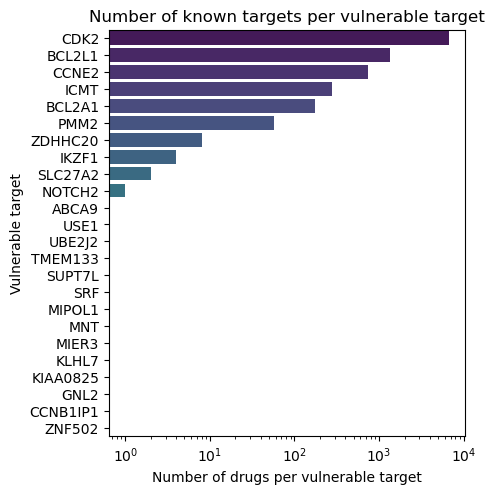

In [66]:
# HOW druggable are the targets? plot the number of pert_ids with a druggable target per vulnerable target (bar chart)
dti_cnts = dtis.groupby('Symbol').agg({'inchi_key': 'nunique'}).reset_index()

plt.figure(figsize=(5, 5))
sbn.barplot(data=dti_cnts, x='inchi_key', y='Symbol', palette='viridis', order=dti_cnts.sort_values('inchi_key', ascending=False).Symbol.tolist())
plt.xlabel('Number of drugs per vulnerable target')
plt.ylabel('Vulnerable target')
plt.title('Number of known targets per vulnerable target')
plt.tight_layout()
plt.xscale('log')
plt.show()

In [67]:
pred_dtis = pd.read_csv('/mnt/c/Users/natha/Downloads/tkgdti_all_results.csv')
pred_dtis.head()

,target,negatives,gnn_ens_score,inhibitor,in_targetome_extended,assay_value,cpx_ens_score,gnn_global_rank,cpx_global_rank,gnn_drug_rank,cpx_drug_rank,ven_mid_lfc,ven_mid_pval,ven_tiers
0,ERBB3,True,0.156210,PD153035,False,NaN,0.839476,1,2074,1.0,1.0,1.971574,6.992075e-23,Tier3
1,PDGFRB,True,0.102534,Tivozanib (AV-951),True,1225.695,0.907266,2,467,1.0,1.0,-0.190792,5.017341e-01,Unassigned
2,ERBB3,True,0.096399,Lapatinib,True,5500.000,0.824366,3,471,1.0,1.0,1.971574,6.992075e-23,Tier3
3,PDGFRA,True,0.076822,RAF265 (CHIR-265),True,1100.000,0.916572,4,2770,1.0,1.0,0.296058,1.388461e-01,Unassigned
4,ERBB3,True,0.074654,Ibrutinib (PCI-32765),False,NaN,0.888486,5,564,1.0,2.0,1.971574,6.992075e-23,Tier3


In [68]:
# how many vulnerable targets are in the predicted dtis? 
targspace = pred_dtis.target.unique().tolist()
pred_vulnerable_targets = list(set(targspace).intersection(set(vulnerable_targets)))
pred_undrugable_vulnerable_targets = list(set(pred_vulnerable_targets).intersection(set(undrugable_vulnerable_targets)))
print(f"Number of vulnerable targets in predicted dtis: {len(pred_vulnerable_targets)}")
print(f"Number of undrugable vulnerable targets in predicted dtis: {len(pred_undrugable_vulnerable_targets)}")

Number of vulnerable targets in predicted dtis: 17
Number of undrugable vulnerable targets in predicted dtis: 8


In [93]:
res1 = pred_dtis[lambda x: x.target.isin(pred_undrugable_vulnerable_targets)].sort_values('gnn_drug_rank', ascending=True).head(100)[['target', 'inhibitor', 'cpx_ens_score', 'gnn_ens_score', 'gnn_drug_rank', 'cpx_drug_rank']]
res2 = pred_dtis[lambda x: x.target.isin(pred_undrugable_vulnerable_targets)].sort_values('cpx_drug_rank', ascending=True).head(100)[['target', 'inhibitor', 'cpx_ens_score', 'gnn_ens_score', 'gnn_drug_rank', 'cpx_drug_rank']]
res = res2.merge(res1, on=list(res2.columns), how='inner').assign(avg_drug_rank= lambda x: (x.gnn_drug_rank + x.cpx_drug_rank) / 2)
res = res.sort_values('avg_drug_rank', ascending=True).reset_index(drop=True)
res.style.hide()

target,inhibitor,cpx_ens_score,gnn_ens_score,gnn_drug_rank,cpx_drug_rank,avg_drug_rank
SRF,Sorafenib,0.545362,0.000014,818.000000,1532.000000,1175.000000
SRF,Olaparib,0.490145,0.000044,1012.000000,1350.000000,1181.000000
SRF,Lapatinib,0.538396,0.000012,2289.000000,594.000000,1441.500000
SRF,Vismodegib (GDC-0449),0.494216,0.000017,2233.000000,700.000000,1466.500000
SRF,PH-797804,0.503408,0.000008,2327.000000,812.000000,1569.500000
SRF,PD153035,0.504947,0.000011,2286.000000,968.000000,1627.000000
SRF,Bosutinib (SKI-606),0.566166,0.000005,1936.000000,1343.000000,1639.500000
SRF,Dasatinib,0.544444,0.000009,1236.000000,2074.000000,1655.000000
SRF,BI-2536,0.551619,0.000009,2176.000000,1176.000000,1676.000000
SRF,GDC-0879,0.459785,0.000036,634.000000,2795.000000,1714.500000


In [5]:
dtis = pd.read_csv('/home/teddy/local/TKG-DTI/extdata/meta/targetome__drug_targets_gene.csv')
dtis.head()

,Symbol,can_smiles,inchikey,inhibitor
0,BAD,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,HPLNQCPCUACXLM-PGUFJCEWSA-N,ABT-737
1,CCND1,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,AHJRHEGDXFFMBM-UHFFFAOYSA-N,Palbociclib
2,CCNT1,CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC...,BIIVYFLTOXDAOV-YVEFUNNKSA-N,Flavopiridol
3,PSMA1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,Bortezomib (Velcade)
4,PSMA2,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,Bortezomib (Velcade)


In [6]:
ven_targs = dtis[lambda x: x.inhibitor == 'Venetoclax'].Symbol.unique()
ven_targs

array(['BCL2', 'BCL2L1', 'BCL2L2'], dtype=object)

In [7]:
xpr[lambda x: x.Gene.isin(ven_targs)]

,Gene,total,not_filtered,num_sig,min_qvalue,min_abslfc,lfc_min,lfc_mean,lfc_max,num_up,num_down,tiers,mid_lfc,mid_pval,sig_mid_lfc,sig_mid_pval,camera_dir,camera_pval,camera_qval
22,BCL2,5,2,2,4.493999e-35,4.924509,4.924509,7.237041,9.549573,2,0,Tier1,9.549573,5.247710e-36,9.549573,5.247710e-36,Up,0.009717,0.476864
63,BCL2L1,5,2,2,6.106329e-07,2.013307,-3.058396,-2.535852,-2.013307,0,2,Tier1,-2.013307,3.741337e-07,-2.013307,3.741337e-07,Down,0.122152,0.999295
845,BCL2L2,5,3,2,1.390623e-08,1.940527,-2.752322,-2.346424,-1.940527,0,2,Tier3,-1.940527,1.000309e-04,-2.752322,6.866627e-09,Down,0.182108,0.999295


In [8]:
preds = pd.read_csv('/home/teddy/local/TKG-DTI/output/from_exacloud/tkge_no_patient/COMPLEX2/FOLD_0/fa5e12b4-7641-43a9-aab4-f366ca7ae27c/predictions.csv')
preds = preds.merge(dtis[['inhibitor', 'inchikey']].drop_duplicates(), left_on='drug_name', right_on='inchikey')
preds.head()

,drug,protein,score,drug_name,prot_name,train,valid,test,negatives,prob,inhibitor,inchikey
0,0,0,-19.109425,AAKJLRGGTJKAMG-UHFFFAOYSA-N,12LO,False,False,False,True,0.390901,Erlotinib,AAKJLRGGTJKAMG-UHFFFAOYSA-N
1,0,1,-22.299408,AAKJLRGGTJKAMG-UHFFFAOYSA-N,15E1.1,False,False,False,True,0.225721,Erlotinib,AAKJLRGGTJKAMG-UHFFFAOYSA-N
2,0,2,-23.237270,AAKJLRGGTJKAMG-UHFFFAOYSA-N,1A13B,False,False,False,True,0.177158,Erlotinib,AAKJLRGGTJKAMG-UHFFFAOYSA-N
3,0,3,-19.456142,AAKJLRGGTJKAMG-UHFFFAOYSA-N,1C7,False,False,False,True,0.372948,Erlotinib,AAKJLRGGTJKAMG-UHFFFAOYSA-N
4,0,4,-22.615509,AAKJLRGGTJKAMG-UHFFFAOYSA-N,1R20,False,False,False,True,0.209353,Erlotinib,AAKJLRGGTJKAMG-UHFFFAOYSA-N


In [ ]:
# KNOWN venetoclax targets
ven_targs = preds[lambda x: (x.inhibitor == 'Venetoclax') & (~x.negatives)]
ven_targs = ven_targs.sort_values('score', ascending=False).reset_index(drop=True)[['inhibitor', 'prot_name', 'prob']]
ven_targs = ven_targs.merge(xpr[['Gene', 'tiers', 'mid_pval', 'mid_lfc']], left_on='prot_name', right_on='Gene').dropna()
ven_targs = ven_targs.assign(dir = lambda x: np.sign(x.mid_lfc))
ven_targs.head().style.hide()

inhibitor,prot_name,prob,Gene,tiers,mid_pval,mid_lfc,dir
Venetoclax,BCL2L1,0.866848,BCL2L1,Tier1,0.000000,-2.013307,-1.000000
Venetoclax,BCL2L2,0.845171,BCL2L2,Tier3,0.000100,-1.940527,-1.000000
Venetoclax,BCL2,0.817977,BCL2,Tier1,0.000000,9.549573,1.000000


In [52]:
# PREDICTED venetoclax targets
pred_ven_targs = preds[lambda x: (x.inhibitor == 'Venetoclax') & (x.negatives)]
pred_ven_targs = pred_ven_targs.sort_values('score', ascending=False).reset_index(drop=True)[['inhibitor', 'prot_name', 'prob']]
pred_ven_targs = pred_ven_targs.merge(xpr[['Gene', 'tiers', 'mid_pval', 'mid_lfc']], left_on='prot_name', right_on='Gene').dropna()
pred_ven_targs = pred_ven_targs.assign(dir = lambda x: np.sign(x.mid_lfc))
pred_ven_targs.head().style.hide()

inhibitor,prot_name,prob,Gene,tiers,mid_pval,mid_lfc,dir
Venetoclax,MCL1,0.778060,MCL1,Singleton,0.000000,-7.291337,-1.000000
Venetoclax,CSNK1D,0.734248,CSNK1D,Unassigned,0.000007,-0.813920,-1.000000
Venetoclax,CD44,0.725825,CD44,Unassigned,0.172304,0.464678,1.000000
Venetoclax,ERBB2,0.723182,ERBB2,Unassigned,0.017284,-0.651755,-1.000000
Venetoclax,PRKCQ,0.713611,PRKCQ,Unassigned,0.003266,0.866222,1.000000


In [53]:
# Overlap between Tier 1 gene essentiality (sens/res) and Top N venetoclax predictions 

mid_pval vs prob: 0.0012211930121490632
mid_pval vs prob (up): 0.008453040329152643
mid_pval vs prob (down): -0.0059768988559898515


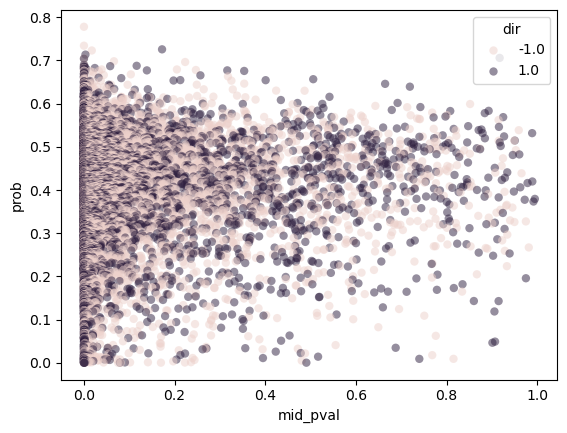

In [54]:
r_all = np.corrcoef(pred_ven_targs['mid_pval'], pred_ven_targs['prob'])[0, 1]
r_up = np.corrcoef(pred_ven_targs[lambda x: x.mid_lfc > 0]['mid_pval'], pred_ven_targs[lambda x: x.mid_lfc > 0]['prob'])[0, 1]
r_down = np.corrcoef(pred_ven_targs[lambda x: x.mid_lfc < 0]['mid_pval'], pred_ven_targs[lambda x: x.mid_lfc < 0]['prob'])[0, 1]
print('mid_pval vs prob:', r_all)
print('mid_pval vs prob (up):', r_up)
print('mid_pval vs prob (down):', r_down)

plt.figure()
sbn.scatterplot(x='mid_pval', y='prob', hue='dir', data=pred_ven_targs, linewidth=0, alpha=0.5)
#plt.plot(pred_ven_targs['mid_pval'], pred_ven_targs['prob'], 'k.', alpha=0.5)
plt.xlabel('mid_pval')
plt.ylabel('prob')
plt.show()

mid_pval vs prob: 0.0012211930121490632
mid_pval vs prob (up): 0.008453040329152643
mid_pval vs prob (down): -0.0059768988559898515


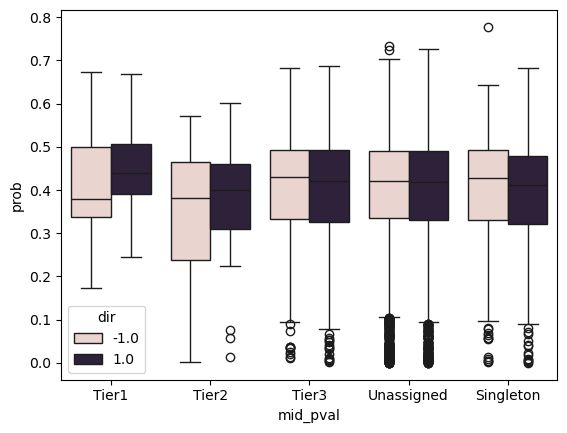

In [55]:
r_all = np.corrcoef(pred_ven_targs['mid_pval'], pred_ven_targs['prob'])[0, 1]
r_up = np.corrcoef(pred_ven_targs[lambda x: x.mid_lfc > 0]['mid_pval'], pred_ven_targs[lambda x: x.mid_lfc > 0]['prob'])[0, 1]
r_down = np.corrcoef(pred_ven_targs[lambda x: x.mid_lfc < 0]['mid_pval'], pred_ven_targs[lambda x: x.mid_lfc < 0]['prob'])[0, 1]
print('mid_pval vs prob:', r_all)
print('mid_pval vs prob (up):', r_up)
print('mid_pval vs prob (down):', r_down)

plt.figure()
sbn.boxplot(x='tiers', y='prob', hue='dir', data=pred_ven_targs, order=['Tier1', 'Tier2', 'Tier3', 'Unassigned', 'Singleton'])
#plt.plot(pred_ven_targs['mid_pval'], pred_ven_targs['prob'], 'k.', alpha=0.5)
plt.xlabel('mid_pval')
plt.ylabel('prob')
plt.show()

# compare to pred to sensitivity (dir: down)

In [ ]:
# all drugs - for use in proposing drug combinations with venetoclax that may improve performance 

In [ ]:
res = preds[lambda x: x.negatives]
res = res.sort_values('score', ascending=False).reset_index(drop=True)[['inhibitor', 'prot_name', 'prob']]
top_res = res.head(1000).merge(xpr[['Gene', 'mid_pval', 'mid_lfc', 'tiers']].sort_values('mid_pval', ascending=True).head(1000), left_on='prot_name', right_on='Gene').dropna()
top_res = top_res.assign(dir = lambda x: np.sign(x.mid_lfc))
top_res.head()

,inhibitor,prot_name,prob,Gene,mid_pval,mid_lfc,tiers,dir
0,AST-487,TBK1,0.936948,TBK1,2.305672e-56,3.155548,Unassigned,1.0
1,PP242,FLT3,0.930647,FLT3,5.631135e-17,3.149828,Tier3,1.0
2,KW-2449,ROS1,0.929243,ROS1,8.316918e-35,2.491905,Unassigned,1.0
3,Canertinib (CI-1033),YES1,0.928267,YES1,4.740599e-17,2.253742,Unassigned,1.0
4,Bosutinib (SKI-606),STK17A,0.926480,STK17A,2.379003e-43,2.961283,Unassigned,1.0


In [36]:
top_res[lambda x: x.dir == 1.0].sort_values('prob', ascending=False).head(100)[lambda x: x.tiers != 'Unassigned']

,inhibitor,prot_name,prob,Gene,mid_pval,mid_lfc,tiers,dir
1,PP242,FLT3,0.930647,FLT3,5.631135e-17,3.149828,Tier3,1.0
5,Bosutinib (SKI-606),FLT3,0.921546,FLT3,5.631135e-17,3.149828,Tier3,1.0
10,R547,CCNA1,0.914475,CCNA1,1.138373e-24,2.223028,Tier3,1.0
14,Cediranib (AZD2171),FLT3,0.908336,FLT3,5.631135e-17,3.149828,Tier3,1.0
16,Sunitinib,CAMK2B,0.902793,CAMK2B,6.568359e-21,2.063115,Singleton,1.0
17,JNJ-28312141,FGFR3,0.901418,FGFR3,4.685633e-50,2.947925,Tier1,1.0
19,Flavopiridol,FLT3,0.898748,FLT3,5.631135e-17,3.149828,Tier3,1.0
20,Midostaurin,FGFR3,0.898584,FGFR3,4.685633e-50,2.947925,Tier1,1.0
22,AST-487,ERBB3,0.898549,ERBB3,6.992075e-23,1.971574,Tier3,1.0
26,Ibrutinib (PCI-32765),ERBB3,0.896246,ERBB3,6.992075e-23,1.971574,Tier3,1.0


In [37]:
top_res[lambda x: x.dir == -1.0].sort_values('prob', ascending=False).head(100)

,inhibitor,prot_name,prob,Gene,mid_pval,mid_lfc,tiers,dir
15,Dasatinib,TGFBR2,0.907564,TGFBR2,3.171275e-17,-2.175926,Unassigned,-1.0
